# Assess QED model performances on ChemBL

In [2]:
import os
import pickle

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
from rdkit.Chem import MolFromSmiles, MolToSmiles, QED

from create_oracle import extract_oracles_from_target_names
from scores import scoring_factory
from utils import get_train_cs_path, get_df_from_chid
from preprocess import _save_train_test_smiles
import matplotlib
import matplotlib.pyplot as plt
from predictive_metrics import score_model
from itertools import permutations

from sklearn.metrics import roc_curve

font = {'size': 16}

matplotlib.rc('font', **font)

In [3]:
def plot_auc_layers(title, y_true, y_predicted, similarities, similarity_bins, y_test_true, y_test_pred, savefig):
    legends = []
    plt.figure(figsize=(10,7))
    for sim_min, sim_max in zip(similarity_bins[:-1], similarity_bins[1:]):
        idxs_similar = np.where((np.array(similarities) >= sim_min) & (np.array(similarities) < sim_max))[0]
        if len(idxs_similar) == 0:
            continue
        y_true_layer, y_predicted_layer = y_true[idxs_similar], y_predicted[idxs_similar]
        scores = score_model(y_true_layer, y_predicted_layer)
        FPR, TPR, _ = roc_curve(y_true_layer, y_predicted_layer)
        if len(FPR) > 10:
            plt.plot(FPR, TPR)
            legends.append(f'{sim_min} < simi < {sim_max}')

    FPR, TPR, _ = roc_curve(y_test_true, y_test_pred)
    plt.plot(FPR, TPR, c='darkblue')
    legends.append(f'Test set (random split)')
    plt.plot([0, 1], [0, 1], 'r--')
    legends.append('random model')
    plt.legend(legends)
    plt.title(title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig, dpi=600, bbox_inches='tight')
    plt.show()

In [4]:
dico_patents = {
    'irak4_bayer': 'Dataset 1',
    'irak4_merck': 'Dataset 2',
    'irak4_pfizer': 'Dataset 3',
    'irak4_roche': 'Dataset 4'
}

In [5]:
def __get_title(chid, target_name, n_mols):
    if target_name == 'QED':
        return f'ROC curves of QED model built on {dico_patents[chid]} \n evaluated on {n_mols} random ChEMBL molecules, by similarity layers  '
    power = target_name.split("_power")[1][:2]
    try:
        power = int(power)
    except:
        power = int(power[0])
    return f'ROC curves of oracle power {power} model built on {dico_patents[chid]} \n evaluated on {n_mols} random ChEMBL molecules, by similarity layers  '

def plot_curves(chid_scores, target_name, test_scores, chembl_scores, chid_simi_scores):
    binned_targ = get_binned_targ(target_name)
    for chid, scores in chid_scores.items():
        y_true, y_predicted = np.array(chembl_scores[chid][binned_targ]), np.array(scores)
        simis = np.array(chid_simi_scores[chid])
        
        plot_auc_layers(
            __get_title(chid, target_name, len(y_true)),
            y_true,
            y_predicted,
            simis,
            [0, 0.3, 0.4, 0.5, 0.6, 1],
            test_scores[chid]['y_true'],
            test_scores[chid]['y_pred'],
            f'211227_layers_plots_600dpi/{chid}_{target_name}_perfs.png'
        )

In [6]:
def get_test_cs_path(chid):
    return get_train_cs_path(chid).replace('train', 'test')

In [7]:
def get_test_molecules(chid):
    with open(get_test_cs_path(chid), 'r') as f:
        return [ele[:-1] for ele in f.readlines()]
    
def get_train_molecules(chid):
    with open(get_train_cs_path(chid), 'r') as f:
        return [ele[:-1] for ele in f.readlines()]

In [13]:
def get_chembl_mols(size=500000, train_mols = None, seed=19):
    if train_mols is None:
        train_mols = pd.concat([pd.read_csv('assays/processed/CHEMBL1909140.csv'), pd.read_csv('assays/processed/CHEMBL1909203.csv'), pd.read_csv('assays/processed/CHEMBL3888429.csv')]).smiles.tolist()
    train_set_mols = [MolToSmiles(MolFromSmiles(ele)) for ele in train_mols]
    with open('data/guacamol_v1_train.smiles', 'r') as f:
        chembl_smiles = [ele[:-1] for ele in f.readlines()]
    np.random.seed(seed)
    random_chembl = np.random.choice(chembl_smiles, size=size+len(train_set_mols), replace=False)
    random_chembl = [MolToSmiles(MolFromSmiles(ele)) for ele in random_chembl]
    return list(set(random_chembl).difference(set(train_set_mols)))[:size]


def get_binned_targ(target: str) -> str:
    if target == 'QED':
        return 'QED_binned'
    return f'oracle_binned_{target}'


def score_oracle_by_batch(smiles_list, oracle, batch_size):
    scores = None
    for idx in tqdm(range(0, len(smiles_list), batch_size)):
        tmp_score = oracle.score(smiles_list[idx: idx+batch_size])
        if scores is None:
            scores = tmp_score
        else:
            for key, val in tmp_score.items():
                scores[key] += val
    return scores
    
def score_model_by_batch(smiles_list, model, batch_size):
    scores = []
    for idx in tqdm(range(0, len(smiles_list), batch_size)):
        scores.append(model.score_list(smiles_list[idx: idx+batch_size]))
    return np.hstack(scores)

def get_chid_scores(chid_list, target_name, random_chembl):
    chid_scores = {}
    for chid in chid_list:
        model = scoring_factory(chid, [target_name])['model_for_optim']
        chid_scores[chid] = score_model_by_batch(random_chembl, model, 2000)
    return chid_scores

def get_test_scores(target_name, chid_list, test_data, oracles):
    binned_targ = get_binned_targ(target_name)
    test_scores = {chid: {} for chid in chid_list}
    for chid, test_smiles in test_data.items():
        if chid not in test_scores.keys():
            continue
        model = scoring_factory(chid, [target_name])['model_for_optim']
        score_list = score_model_by_batch(test_smiles, model, 10000)
        y_true = score_oracle_by_batch(test_smiles, oracles[chid], 10000)[binned_targ]
        test_scores[chid]['y_true'] = y_true
        test_scores[chid]['y_pred'] = score_list
    return test_scores

def plot_prop_good(test_scores, target_name):
    binned_targ = get_binned_targ(target_name)
    prop_good, legend = [], []
    for chid, dico in test_scores.items():
        prop_good.append(np.sum(dico['y_true'])/ len(dico['y_true']))
        legend.append(chid)
        prop_good.append(np.sum(chembl_scores[chid][binned_targ])/ len(chembl_scores[chid][binned_targ]))
        legend.append(f'ChEMBL w {chid}')
    plt.plot(prop_good, 'o')
    plt.xticks(list(range(len(legend))), legend, rotation=30)
    
    
def compute_similarities(chid_list, random_chembl, test_data):
    chid_simi_scores = {}
    test_simi_scores = {}
    for chid in chid_list:
        similarity_oracle = extract_oracles_from_target_names(chid, ['similarity'])[0]
        chid_simi_scores[chid] = similarity_oracle.score(random_chembl)['similarity']
        test_simi_scores[chid] = similarity_oracle.score(test_data[chid])['similarity']
    return chid_simi_scores, test_simi_scores

In [14]:
target_name_template = 'target_1targs_power{}_seed{}_targid0'
powers = [6, 15]
seeds = [19, 22, 23]
target_names =  ['QED'] + [target_name_template.format(power, seed) for power in powers for seed in seeds]
#chid_list = ['CHEMBL3888429', 'CHEMBL1909140', ]#'CHEMBL1909203']
chid_list = ['irak4_bayer', 'irak4_merck', 'irak4_pfizer', 'irak4_roche']#'CHEMBL1909203']


In [15]:
target_names

['QED',
 'target_1targs_power6_seed19_targid0',
 'target_1targs_power6_seed22_targid0',
 'target_1targs_power6_seed23_targid0',
 'target_1targs_power15_seed19_targid0',
 'target_1targs_power15_seed22_targid0',
 'target_1targs_power15_seed23_targid0']

In [16]:
def get_scoring(chid, target_name, save_dir=None):
    if save_dir is not None:
        savefile = os.path.join(save_dir, f'{chid}_{target_name}.p')
        if os.path.exists(savefile):
            chid_scores, target_name, test_scores, chembl_scores, chid_simi_scores, test_simi_scores = pickle.load(open(savefile, 'rb'))
            return chid_scores, target_name, test_scores, chembl_scores, chid_simi_scores, test_simi_scores
    chid_list = [chid]
    test_data = {chid: get_test_molecules(chid) for chid in chid_list}
    random_chembl = get_chembl_mols(train_mols=get_train_molecules(chid))
    oracles = {chid: extract_oracles_from_target_names(chid, [target_name])[0] for chid in chid_list}
    chembl_scores = {chid: score_oracle_by_batch(random_chembl, oracle, 2000) for chid, oracle in oracles.items()}
    chid_scores = get_chid_scores(chid_list, target_name, random_chembl)
    test_scores = get_test_scores(target_name, chid_list, test_data, oracles)
    chid_simi_scores, test_simi_scores = compute_similarities(chid_list, random_chembl, test_data)
    if save_dir is not None:
        pickle.dump((chid_scores, target_name, test_scores, chembl_scores, chid_simi_scores, test_simi_scores), open(savefile, 'wb'))
    return chid_scores, target_name, test_scores, chembl_scores, chid_simi_scores, test_simi_scores

In [17]:
import seaborn as sns

sns.set(font_scale=1.6)

plt.style.use('seaborn-colorblind')
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.size'] = '50'
#plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

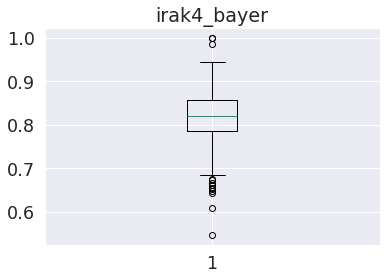

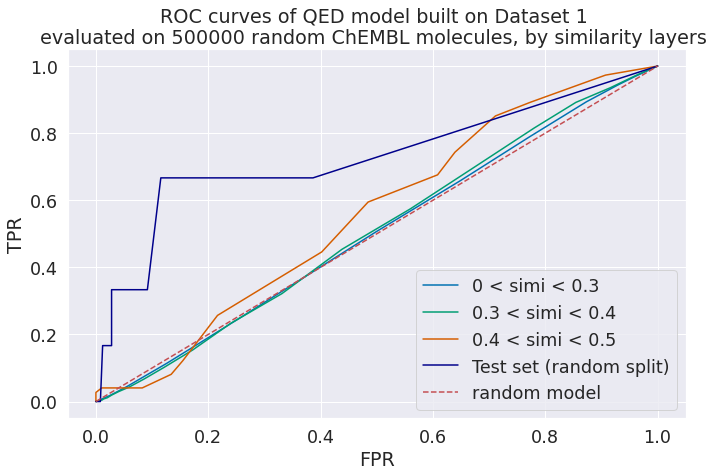

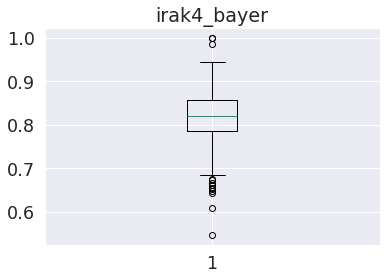

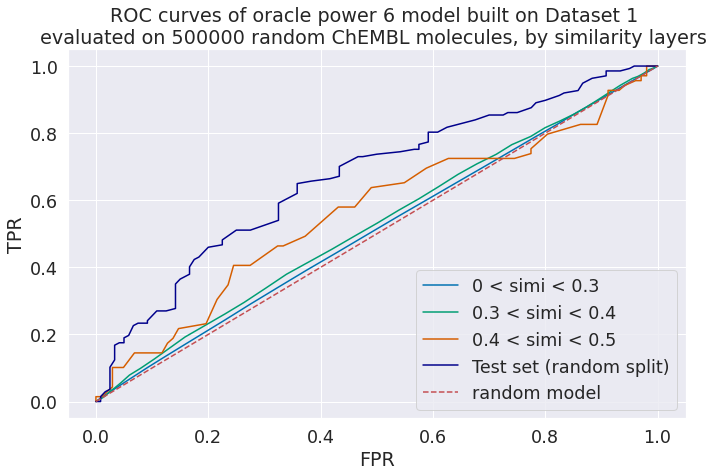

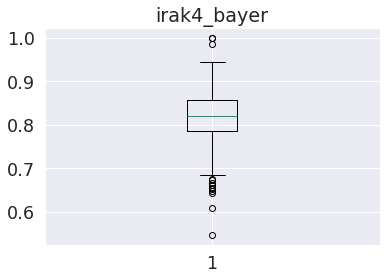

/home/philippe.gendreau/.conda/envs/poetry-propre/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:780: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


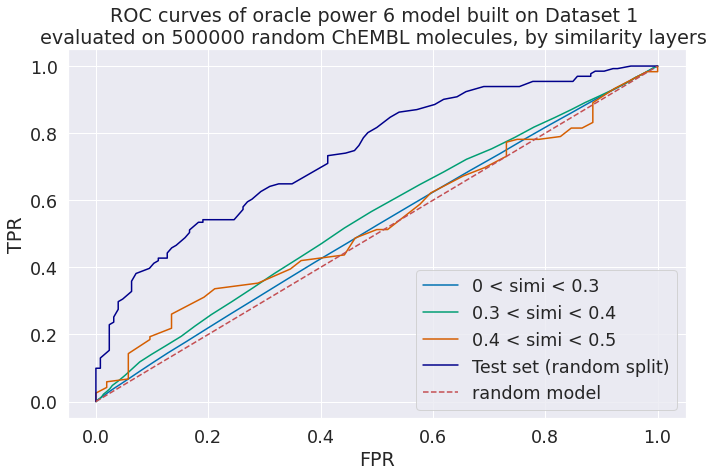

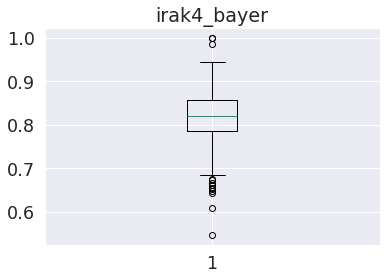

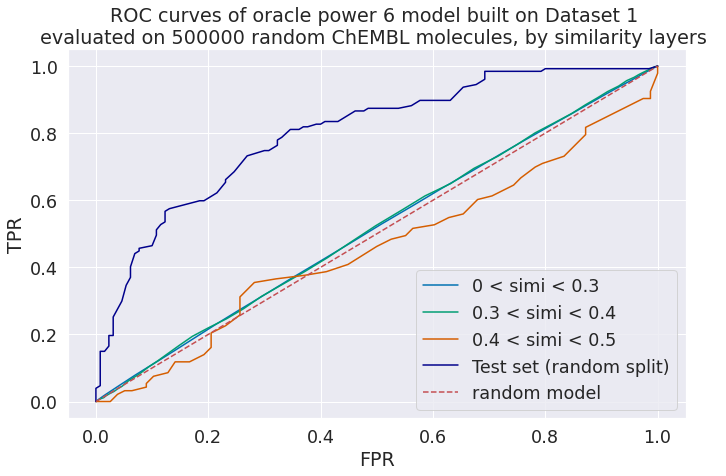

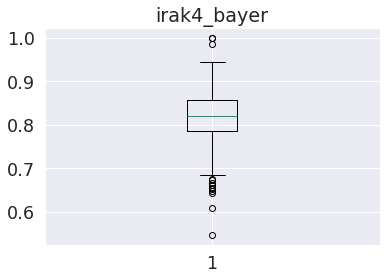

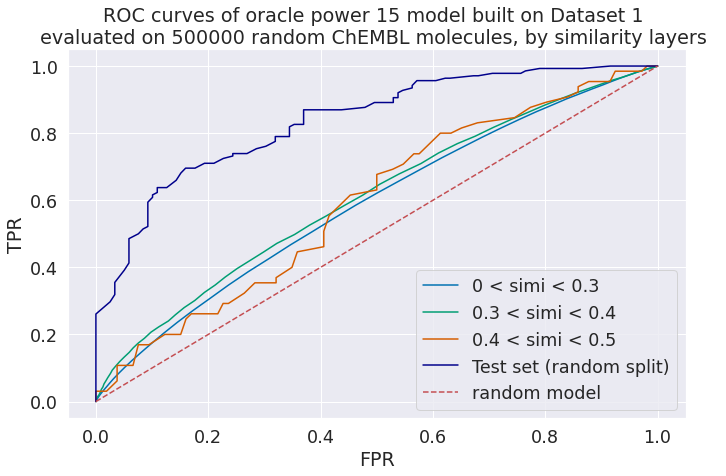

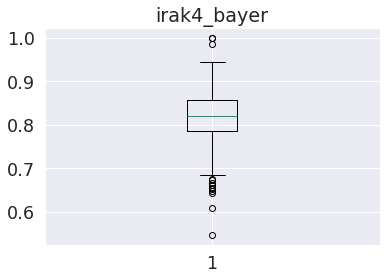

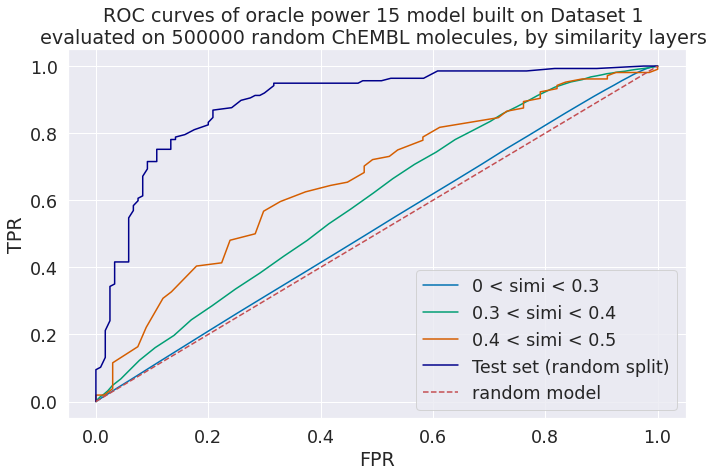

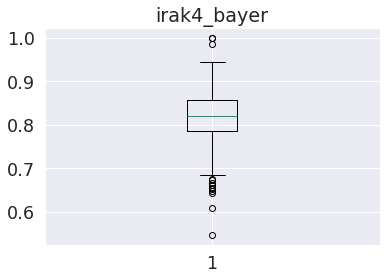

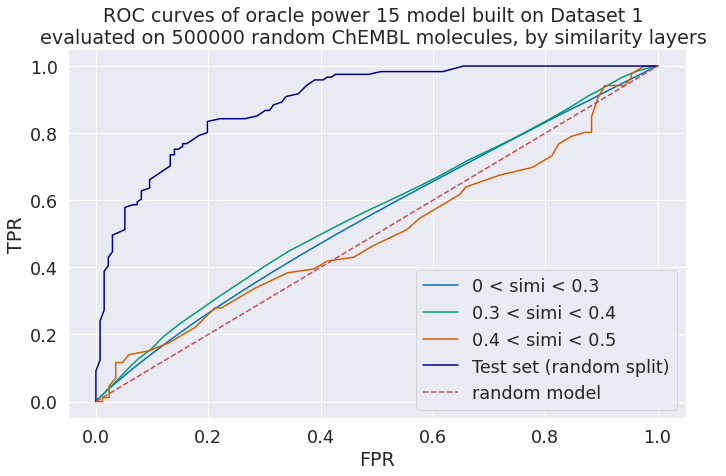

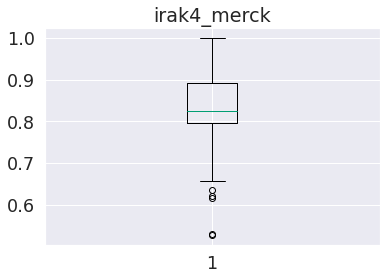

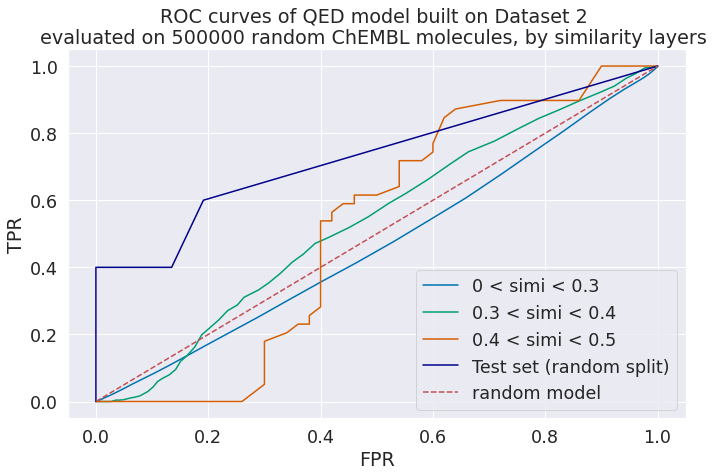

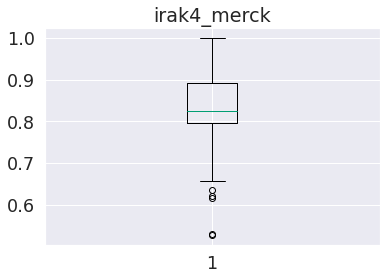

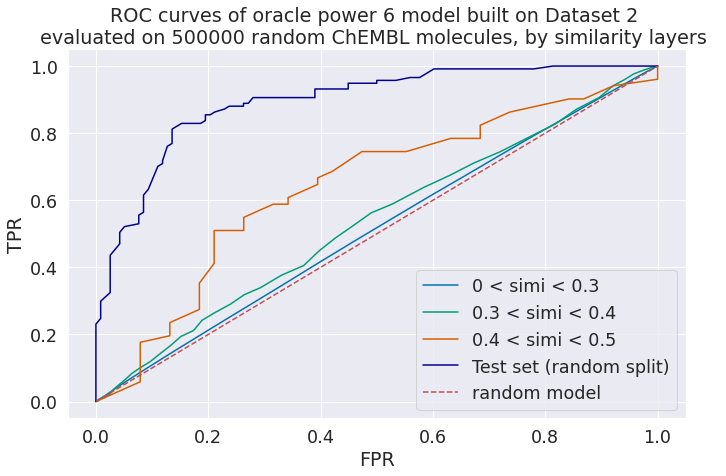

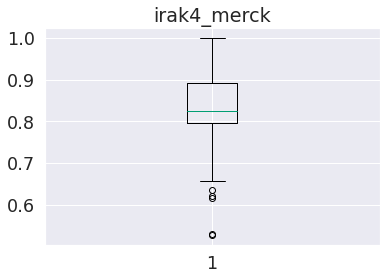

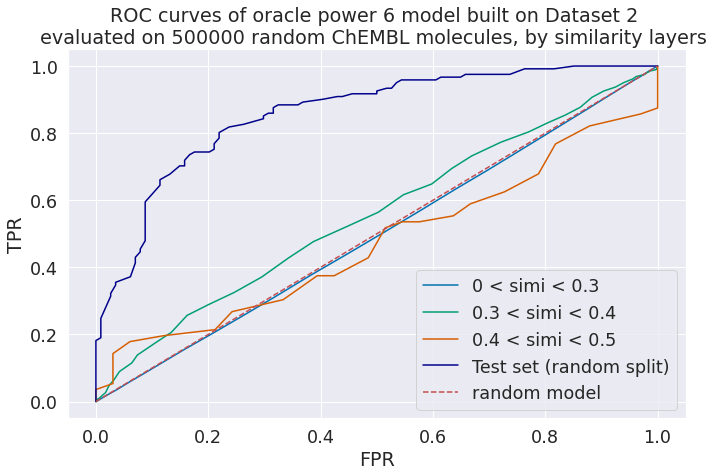

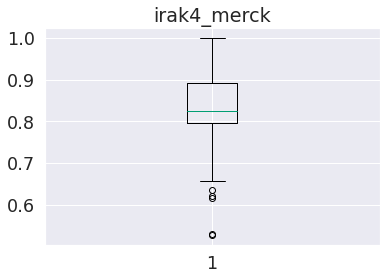

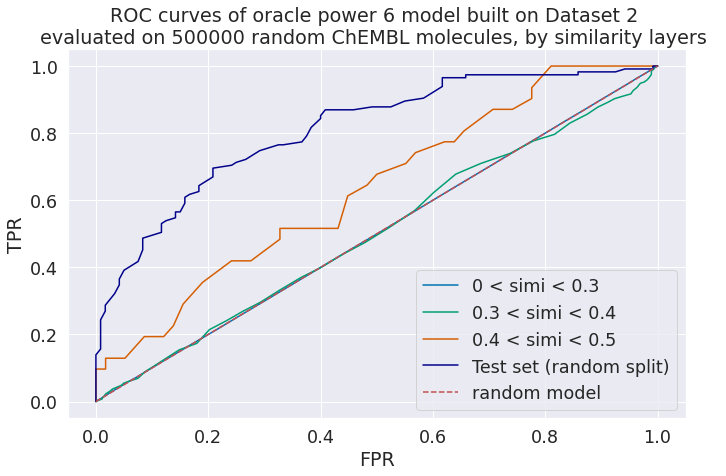

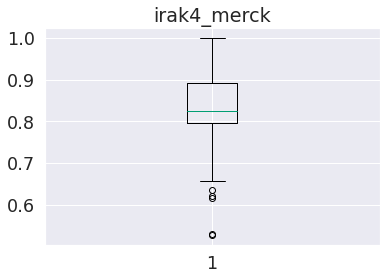

/home/philippe.gendreau/.conda/envs/poetry-propre/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:780: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


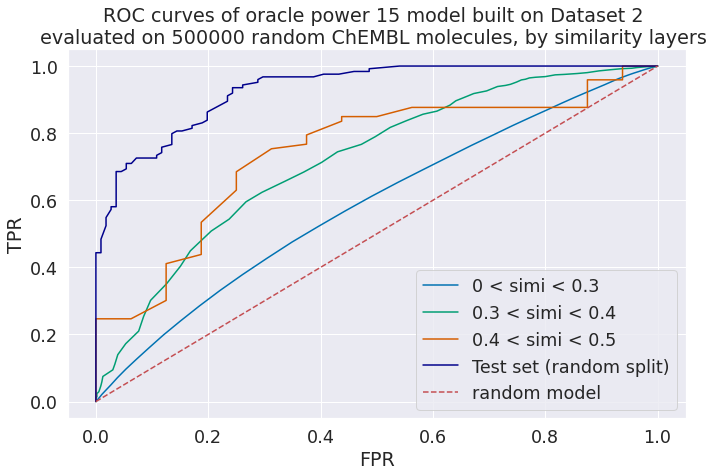

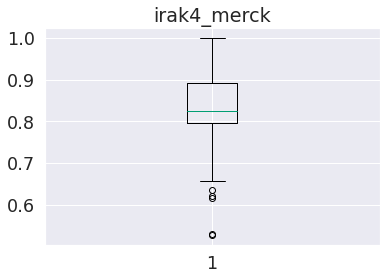

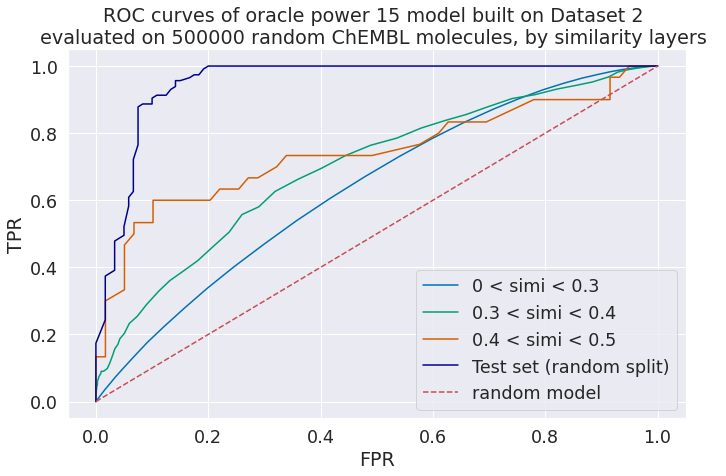

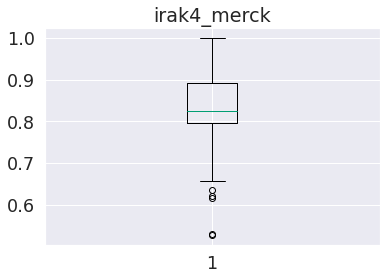

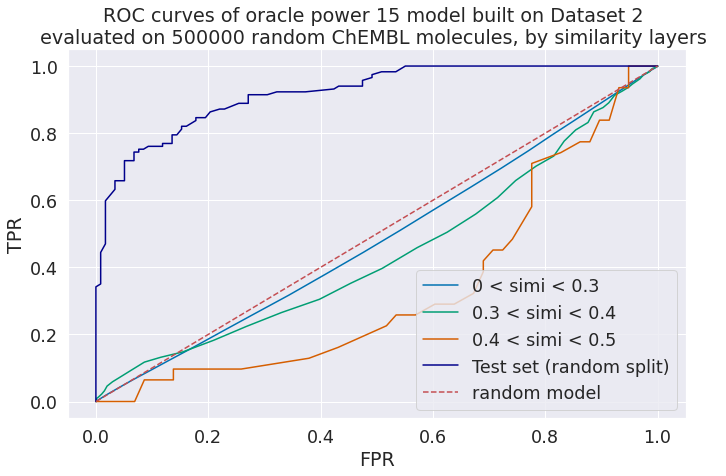

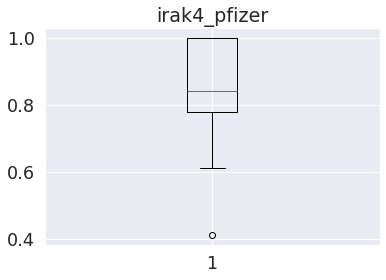

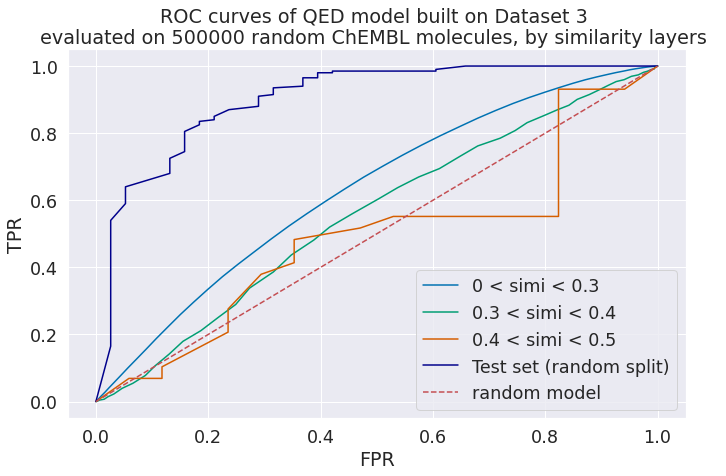

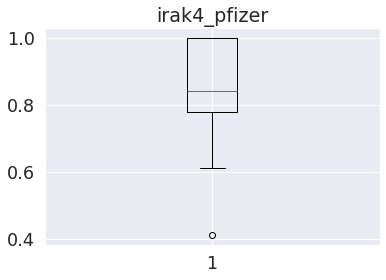

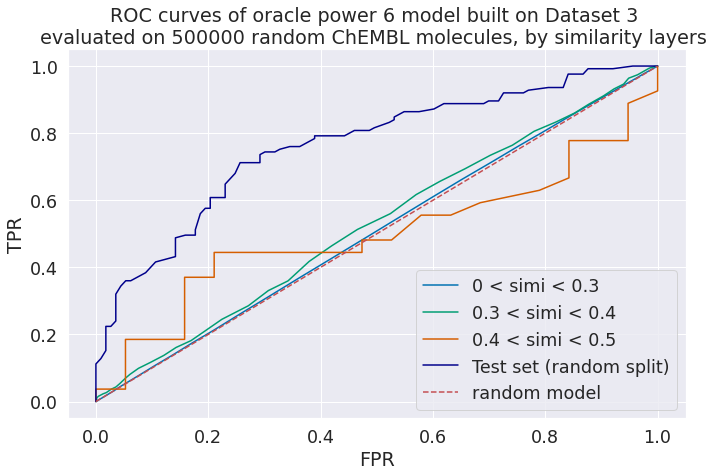

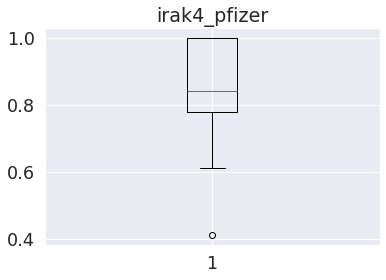

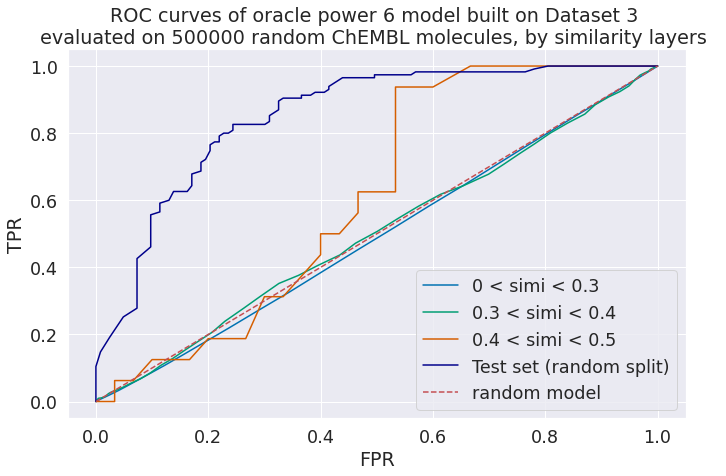

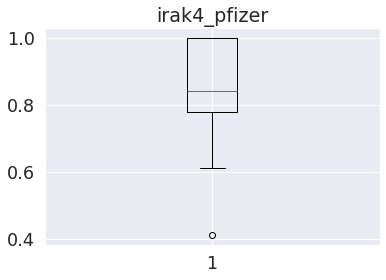

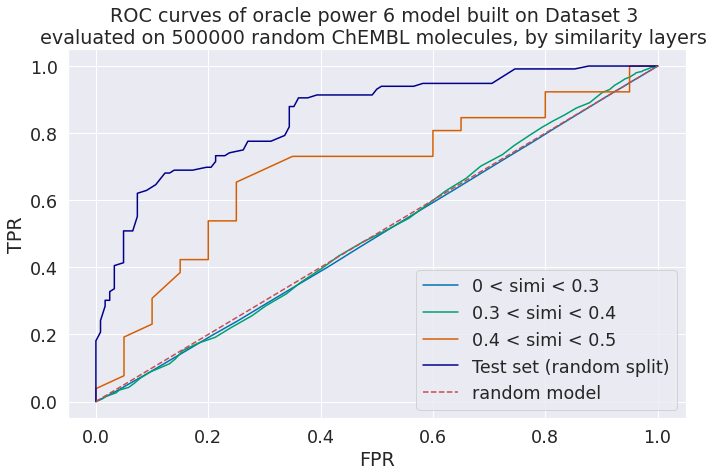

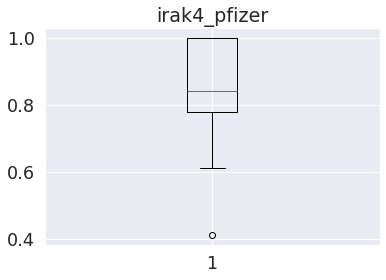

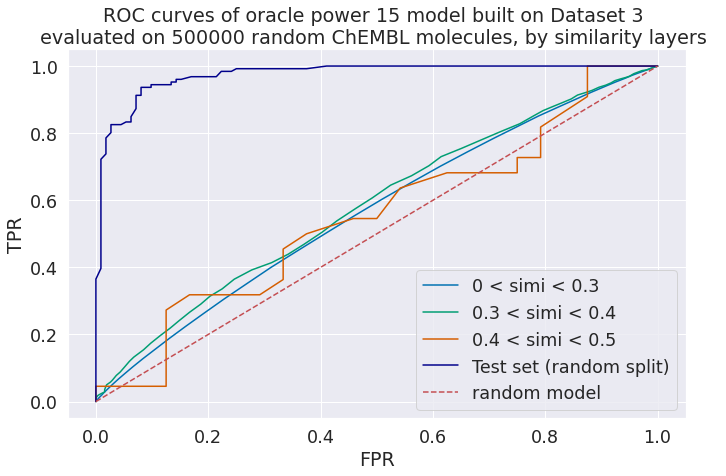

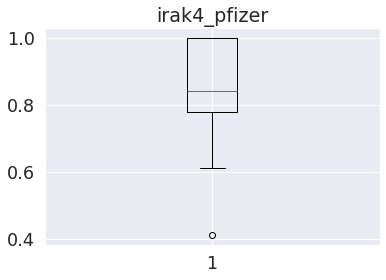

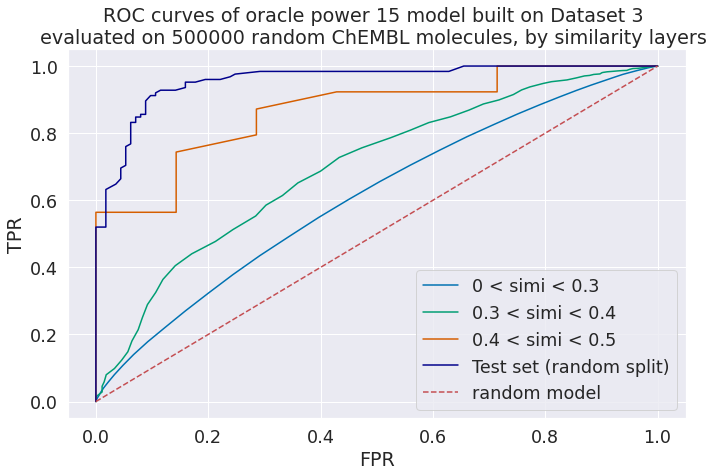

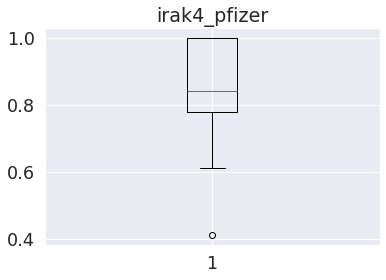

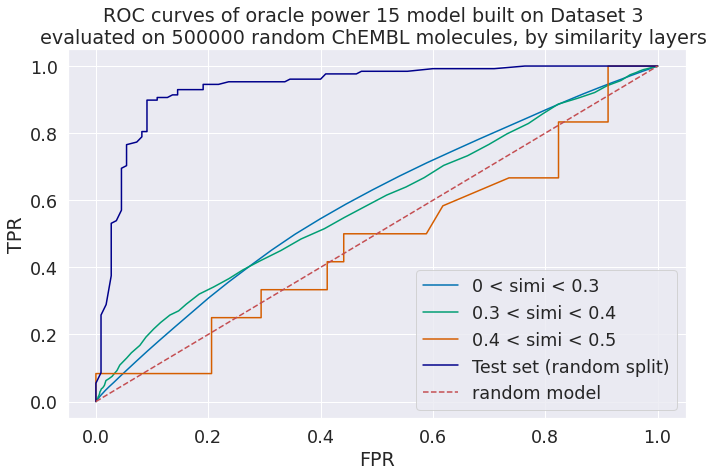

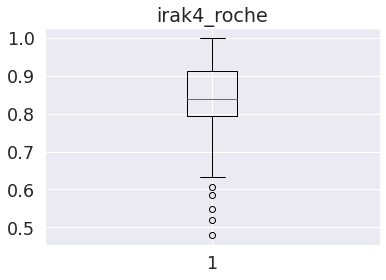

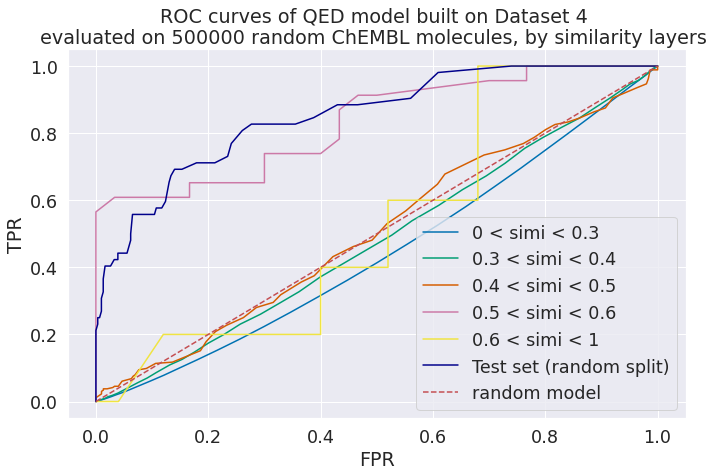

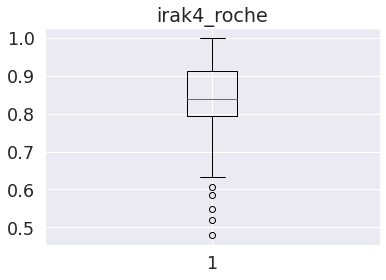

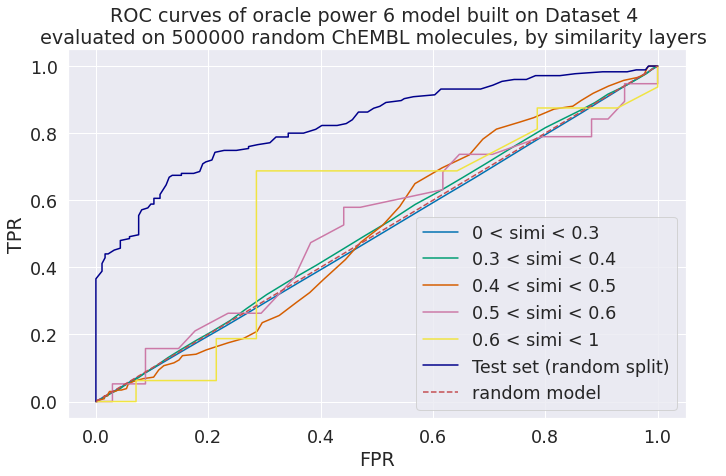

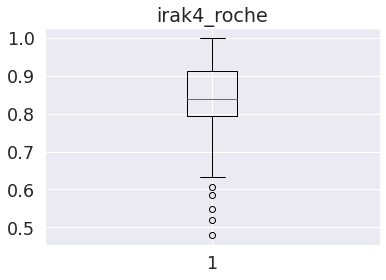

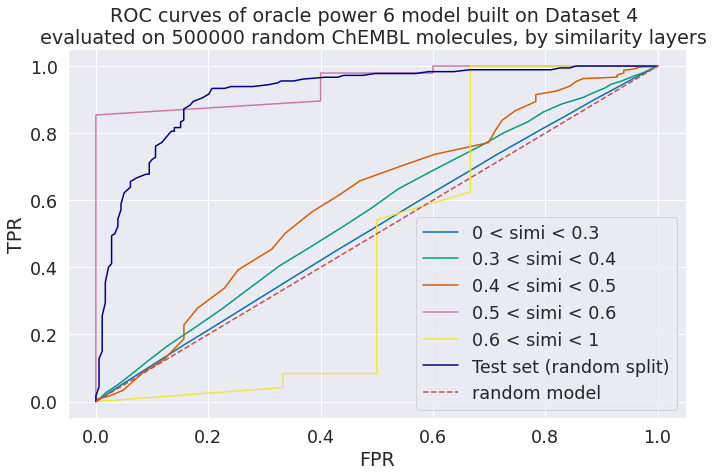

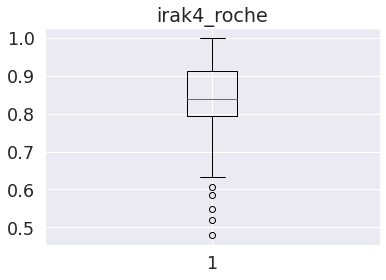

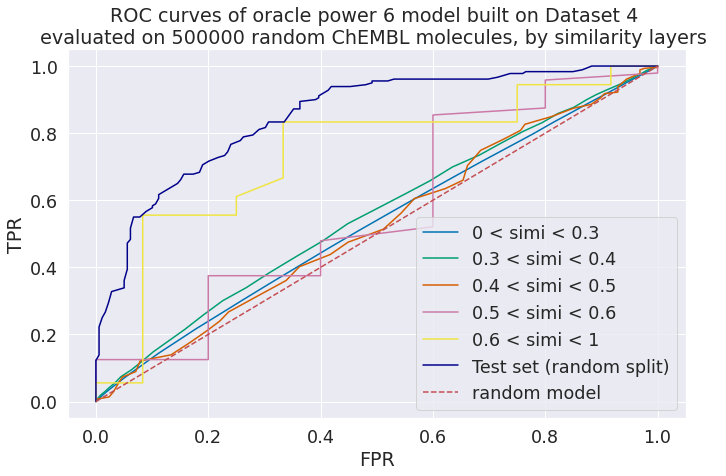

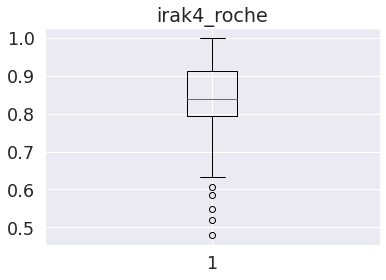

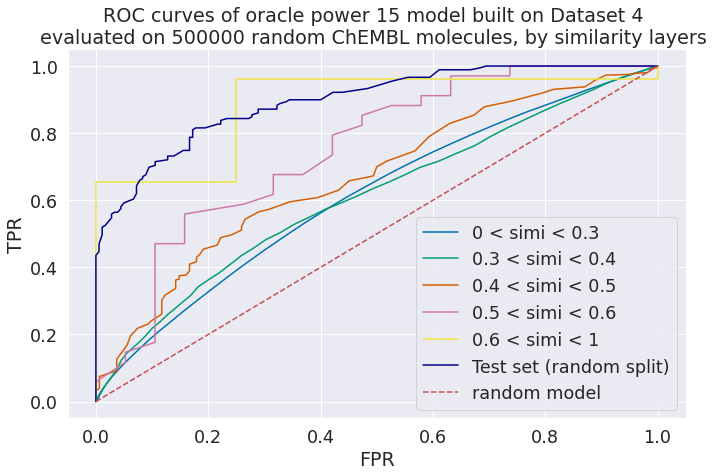

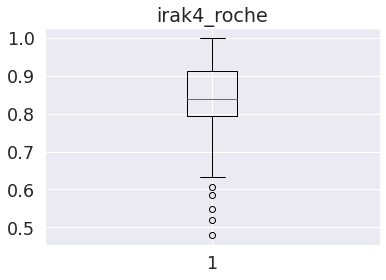

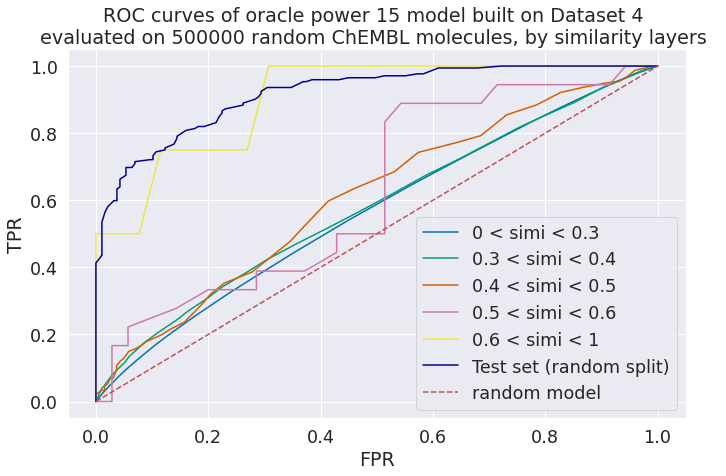

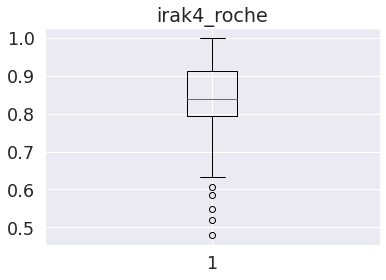

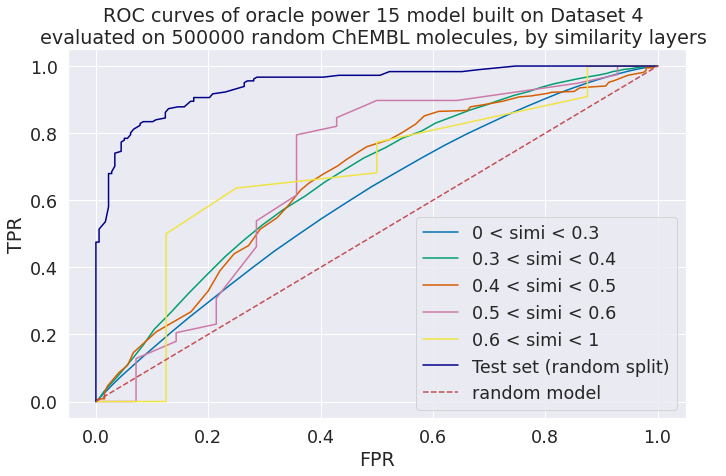

In [18]:
for chid in chid_list:
    for target_name in target_names:
        chid_scores, target_name, test_scores, chembl_scores, chid_simi_scores, test_simi_scores = get_scoring(chid, target_name, 'oracle_scoring_on_chembl')
        for chid, simis in test_simi_scores.items():
            plt.boxplot(simis)
            plt.title(chid)
            plt.show()
        plot_curves(
            chid_scores,
            target_name,
            test_scores,
            chembl_scores,
            chid_simi_scores
        )